# Transfer Learning on Hagrid Dataset

In [1]:
# set the python env so that we can use the project utils
import sys

sys.path.append("/home/panos/WSL_projects/sign-language-image-detection")

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

import src.utils.keras_dataset_utils as keras_dataset_utils

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-01-24 17:46:35.432238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737733596.091065     702 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737733596.239183     702 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 17:46:37.878371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


## Normalization

The following methond will be used to normalize the data

In [2]:
import numpy as np

# Function to calculate mean and std
def calculate_mean_std(dataset):
    
    # Placeholders for mean and squared mean
    psum = tf.zeros([3], dtype=tf.float32)
    psum_sq = tf.zeros([3], dtype=tf.float32)
    count = 0
    # Loop through images
    for inputs, _ in tqdm(dataset):

        inputs = inputs / 255.0
        
        psum += tf.reduce_sum(inputs, axis=[0, 1, 2])  # Sum over the batch and spatial dimensions
        psum_sq += tf.reduce_sum(tf.square(inputs), axis=[0, 1, 2])  # Sum of squares

        count += inputs.shape[0]

    count = count * 512 * 512

    # Mean and STD
    total_mean = psum / count
    total_var = (psum_sq / count) - tf.square(total_mean)
    total_std = tf.sqrt(total_var)

    # Output
    print('Training data stats:')
    print('- mean:', total_mean.numpy())
    print('- std: ', total_std.numpy())

    return total_mean.numpy(), total_std.numpy()
    

Load the whole dataset and find the mean and variance

In [15]:
dataset_path = "/home/panos/WSL_projects/sign-language-image-detection/sign_datasets/hagrid-classification-512p_dataset/hagrid-classification-512p"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the images
    image_size=(512, 512),
    batch_size=4,
    shuffle=True
)

Found 507050 files belonging to 18 classes.


In [31]:
mean, std = calculate_mean_std(dataset)

pprint(f'Mean: {mean}')
pprint(f'Std: {std}')

del dataset

100%|██████████| 126763/126763 [15:31<00:00, 136.06it/s]

Training data stats:
- mean: [0.5778126  0.516726   0.48417425]
- std:  [0.25172076 0.24928826 0.24764916]
'Mean: [0.5778126  0.516726   0.48417425]'
'Std: [0.25172076 0.24928826 0.24764916]'


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [2]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("/home/panos/WSL_projects/sign-language-image-detection/sign_datasets/hagrid-classification-512p_dataset/hagrid-classification-512p/call/0a001cbf-c231-4300-abb1-8c835bd516c6.jpeg")

print(f'Image dimentions: {img.size}')

Image dimentions: (512, 512)


In [3]:
dataset_path = "/home/panos/WSL_projects/sign-language-image-detection/sign_datasets/hagrid-classification-512p_dataset/hagrid-classification-512p"

# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset_path,
#     # Resize the images
#     image_size=(512, 512),
#     batch_size=64,
#     shuffle=True
# )

train_dataset, temp_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224), #reshape the images to 224 x 224 in order to be supported by our models
    batch_size=32, # Smaller batch size to fit in memory
    validation_split=0.2,
    shuffle=True,
    seed=42,
    subset="both",
)

def normalize_image(image, label):
    # TODO: Apply normalization
    precomputed_mean = [0.5778126, 0.516726, 0.48417425]
    precomputed_std = [0.25172076, 0.24928826, 0.24764916]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label

# Split the dataset into training, validation, and test sets
# Define the split ratios
test_size =  int(0.5 * len(temp_dataset)) # 10% for testing and 10% for validation
val_dataset = temp_dataset.take(test_size)
test_dataset = temp_dataset.skip(test_size)

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = val_dataset.map(normalize_image)
# # Create the training, validation, and test datasets
# train_dataset = dataset.take(train_size)
# val_dataset = dataset.skip(train_size).take(val_size)
# test_dataset = dataset.skip(train_size + val_size)

# Prefetching for performance
AUTOTUNE = 1
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 507050 files belonging to 18 classes.
Using 405640 files for training.
Using 101410 files for validation.


I0000 00:00:1737733639.266605     702 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


## Visualizations

Bellow we can see some visualizations for this dataset

In [ ]:
keras_dataset_utils.plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

  0%|          | 1/792 [00:01<18:36,  1.41s/it]2025-01-22 21:12:17.304777: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 1073741824 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1737573137.304836    7830 device_host_allocator.h:61] could not allocate pinned host memory of size: 1073741824
2025-01-22 21:12:17.463066: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 966367744 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1737573137.463124    7830 device_host_allocator.h:61] could not allocate pinned host memory of size: 966367744
2025-01-22 21:12:17.600748: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 869731072 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1737573137.600814    7830 device_host_allocator.h:61] could not allocate pinned host memory of size

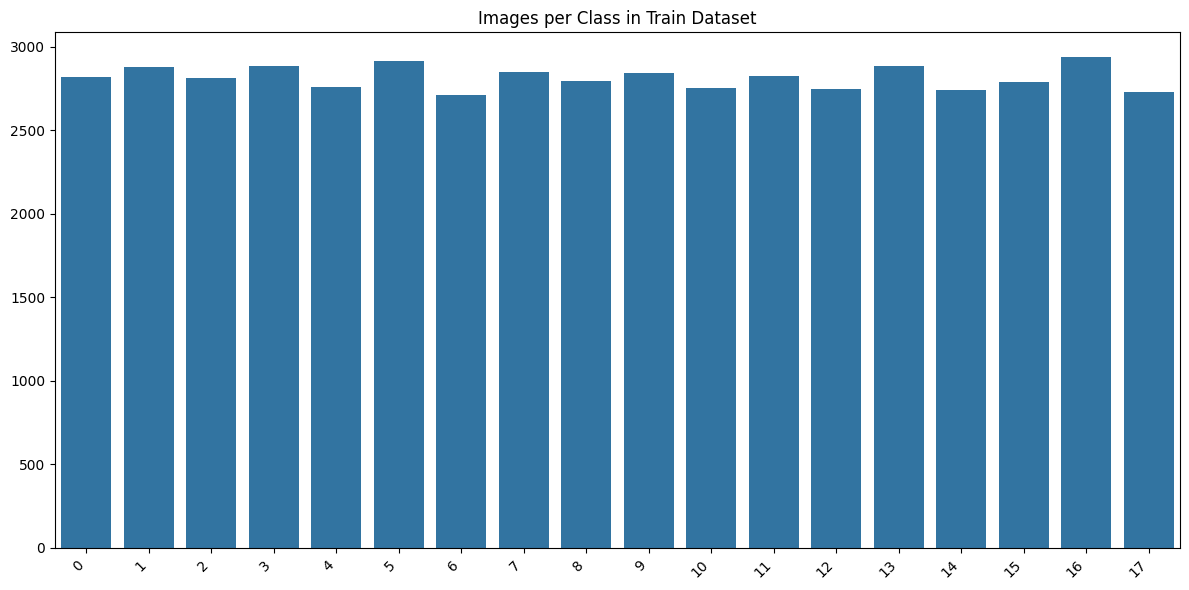

In [8]:
keras_dataset_utils.plot_class_distribution(val_dataset, "Images per Class in Validation Dataset")

  0%|          | 1/793 [00:41<9:12:27, 41.85s/it]2025-01-22 21:18:07.533421: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 2147483648 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1737573487.533471   10339 device_host_allocator.h:61] could not allocate pinned host memory of size: 2147483648
2025-01-22 21:18:07.548218: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 1932735232 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1737573487.548247   10339 device_host_allocator.h:61] could not allocate pinned host memory of size: 1932735232
2025-01-22 21:18:07.562754: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 1739461632 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1737573487.562783   10339 device_host_allocator.h:61] could not allocate pinned host memory of

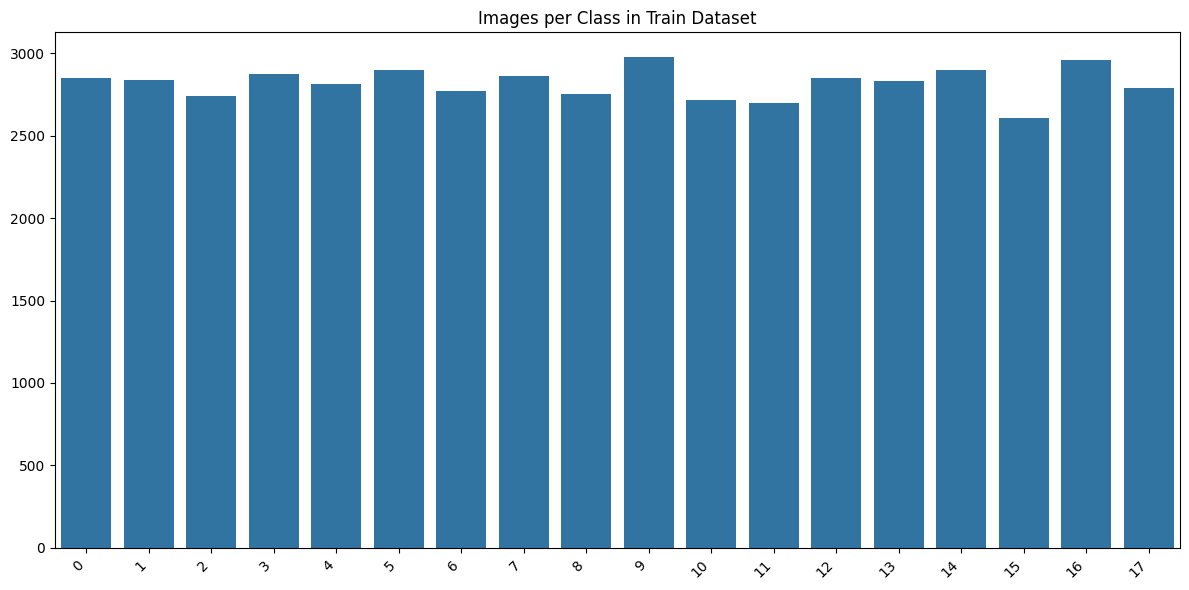

In [9]:
keras_dataset_utils.plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [4]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Calculating class names"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [5]:
class_names = get_class_names(test_dataset=test_dataset)

Calculating class names: 100%|██████████| 1585/1585 [08:22<00:00,  3.15it/s]


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

### Base Version

This classification head is `the same as the ASL Dataset`

We will train for two epochs

In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

print(model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,923,090 (11.15 MB)

 Trainable params: 665,106 (2.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/3


I0000 00:00:1737652983.527830    4104 service.cc:148] XLA service 0x7fc420003590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737652983.527862    4104 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-01-23 19:23:03.926456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737652984.781754    4104 cuda_dnn.cc:529] Loaded cuDNN version 90300


    2/12677 ━━━━━━━━━━━━━━━━━━━━ 19:05 90ms/step - accuracy: 0.0938 - loss: 3.5094  

I0000 00:00:1737652995.739063    4104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1184s 92ms/step - accuracy: 0.5720 - loss: 1.2915 - val_accuracy: 0.6675 - val_loss: 0.9854
Epoch 2/3
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1098s 87ms/step - accuracy: 0.6554 - loss: 1.0261 - val_accuracy: 0.6871 - val_loss: 0.9320
Epoch 3/3
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1046s 83ms/step - accuracy: 0.6751 - loss: 0.9694 - val_accuracy: 0.6915 - val_loss: 0.9238


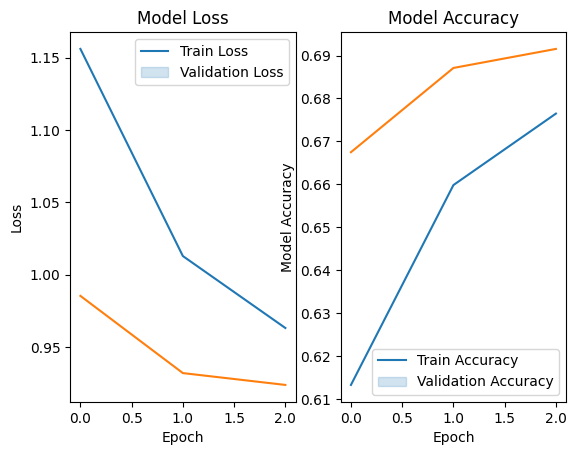

In [8]:
keras_dataset_utils.plot_keras_history(history=history)

### Complex Version

We will also try a more complex version

In [9]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

print(model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,052,882 (11.65 MB)

 Trainable params: 793,362 (3.03 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

None
Epoch 1/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1006s 78ms/step - accuracy: 0.5329 - loss: 1.4285 - val_accuracy: 0.6489 - val_loss: 1.0504
Epoch 2/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1076s 85ms/step - accuracy: 0.6123 - loss: 1.1704 - val_accuracy: 0.6668 - val_loss: 0.9912
Epoch 3/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1026s 81ms/step - accuracy: 0.6283 - loss: 1.1242 - val_accuracy: 0.6684 - val_loss: 0.9829
Epoch 4/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1066s 84ms/step - accuracy: 0.6366 - loss: 1.1009 - val_accuracy: 0.6769 - val_loss: 0.9629
Epoch 5/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 1267s 100ms/step - accuracy: 0.6426 - loss: 1.0814 - val_accuracy: 0.6832 - val_loss: 0.9485


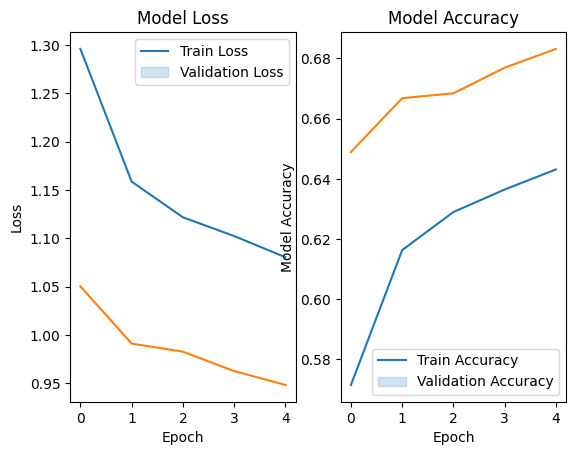

In [10]:
keras_dataset_utils.plot_keras_history(history=history)

## EfficientNet Transfer Learning

Let's try to finetune `EfficientNetB7` for our task.

EfficientNetB7 is trained on the `imagenet` dataset

### Base Version

In [7]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,418,153 (249.55 MB)

 Trainable params: 1,320,466 (5.04 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

None
Epoch 1/5


I0000 00:00:1737664706.219038   31409 service.cc:148] XLA service 0x7fb784002190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737664706.219075   31409 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-01-23 22:38:27.666475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737664713.465795   31409 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-23 22:38:55.209344: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-23 22:38:56.239120: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran 

12677/12677 ━━━━━━━━━━━━━━━━━━━━ 8433s 658ms/step - accuracy: 0.2550 - loss: 2.3366 - val_accuracy: 0.3493 - val_loss: 2.0284
Epoch 2/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 8453s 667ms/step - accuracy: 0.3402 - loss: 2.0570 - val_accuracy: 0.3614 - val_loss: 1.9855
Epoch 3/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 8460s 667ms/step - accuracy: 0.3618 - loss: 1.9895 - val_accuracy: 0.3804 - val_loss: 1.9296
Epoch 4/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 8454s 667ms/step - accuracy: 0.3741 - loss: 1.9497 - val_accuracy: 0.3941 - val_loss: 1.8848
Epoch 5/5
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 8419s 664ms/step - accuracy: 0.3814 - loss: 1.9231 - val_accuracy: 0.4086 - val_loss: 1.8520


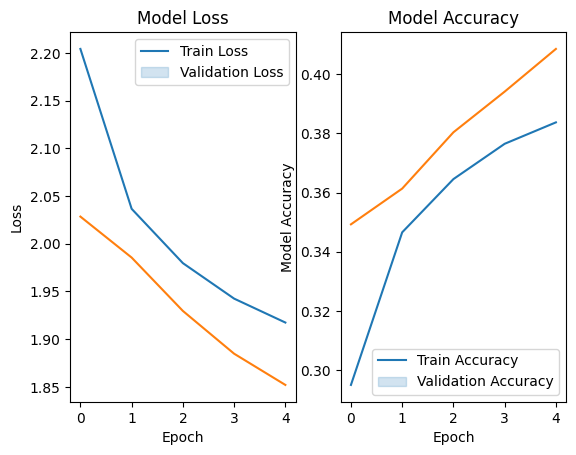

In [8]:
keras_dataset_utils.plot_keras_history(history=history)

### Complex Version

In [9]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,547,945 (250.05 MB)

 Trainable params: 1,448,722 (5.53 MB)

 Non-trainable params: 64,099,223 (244.52 MB)

None
Epoch 1/5
 3169/12677 ━━━━━━━━━━━━━━━━━━━━ 1:38:09 619ms/step - accuracy: 0.1488 - loss: 2.7754

KeyboardInterrupt: 

In [ ]:
keras_dataset_utils.plot_keras_history(history=history)

## ResNet50 Transfer Learning

Let's try to finetune `ResNet50` for our task.

This model is originally trained on the `imagenet` dataset.

### Base Version

In [9]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation="softmax"),
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,646,034 (94.02 MB)

 Trainable params: 1,058,322 (4.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/10
12676/12677 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.3024 - loss: 2.1630

2025-01-24 19:08:12.781076: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-24 19:08:13.501387: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward"

12677/12677 ━━━━━━━━━━━━━━━━━━━━ 3805s 299ms/step - accuracy: 0.3024 - loss: 2.1630 - val_accuracy: 0.4143 - val_loss: 1.8101
Epoch 2/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2673s 211ms/step - accuracy: 0.3967 - loss: 1.8583 - val_accuracy: 0.4262 - val_loss: 1.7600
Epoch 3/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2656s 209ms/step - accuracy: 0.4178 - loss: 1.7928 - val_accuracy: 0.4401 - val_loss: 1.7205
Epoch 4/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2532s 200ms/step - accuracy: 0.4292 - loss: 1.7523 - val_accuracy: 0.4496 - val_loss: 1.6866
Epoch 5/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2460s 194ms/step - accuracy: 0.4399 - loss: 1.7231 - val_accuracy: 0.4596 - val_loss: 1.6667
Epoch 6/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2461s 194ms/step - accuracy: 0.4473 - loss: 1.6994 - val_accuracy: 0.4554 - val_loss: 1.6789
Epoch 7/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2460s 194ms/step - accuracy: 0.4518 - loss: 1.6803 - val_accuracy: 0.4675 - val_loss: 1.6511
Epoch 8/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 2539s 20

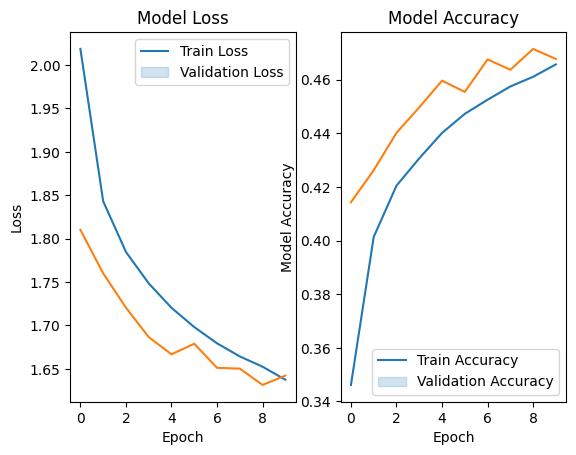

In [10]:
keras_dataset_utils.plot_keras_history(history=history)

### Complex Version

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names), activation="softmax"),
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

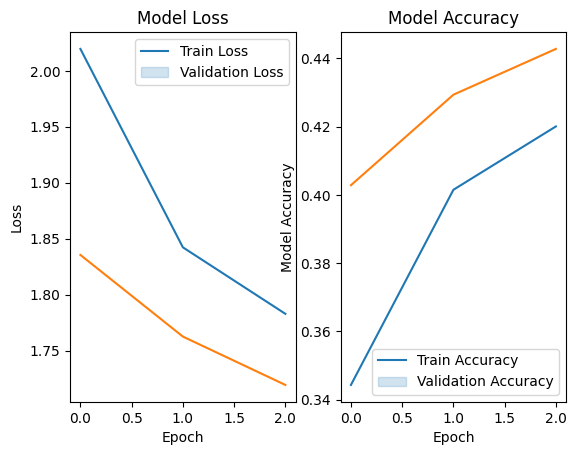

In [9]:
keras_dataset_utils.plot_keras_history(history=history)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

In [11]:
base_model = tf.keras.applications.ConvNeXtBase(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,100,498 (336.08 MB)

 Trainable params: 534,034 (2.04 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

None
Epoch 1/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 11389s 896ms/step - accuracy: 0.6331 - loss: 1.0918 - val_accuracy: 0.7551 - val_loss: 0.6970
Epoch 2/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 11351s 895ms/step - accuracy: 0.7473 - loss: 0.7314 - val_accuracy: 0.7684 - val_loss: 0.6734
Epoch 3/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 11348s 895ms/step - accuracy: 0.7664 - loss: 0.6762 - val_accuracy: 0.7790 - val_loss: 0.6321
Epoch 4/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 11346s 895ms/step - accuracy: 0.7772 - loss: 0.6432 - val_accuracy: 0.7948 - val_loss: 0.5957
Epoch 5/10
12677/12677 ━━━━━━━━━━━━━━━━━━━━ 11512s 908ms/step - accuracy: 0.7848 - loss: 0.6195 - val_accuracy: 0.7978 - val_loss: 0.5874
Epoch 6/10
 5656/12677 ━━━━━━━━━━━━━━━━━━━━ 1:35:47 819ms/step - accuracy: 0.7903 - loss: 0.6025

KeyboardInterrupt: 

In [ ]:
keras_dataset_utils.plot_keras_history(history=history)

## Finetune the whole model

Since this dataset is more challenging, in the following cells we will attempt to train the entire model to see the relative performance

### MobileNet Finetunning

Let's try the MobileNet which is the smaller **without freezing**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
# WE WANT to train the whole model
base_model.trainable = True

# Add custom layers on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        # This is added to reduce the number of parameters
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

print(model.summary())

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)